In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pennylane as qml
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
dev = qml.device("lightning.qubit", wires=1)

In [3]:
@qml.qnode(device=dev, interface="tf")
def circuit(inputs, weights):
    for layer in range(weights.shape[0]):
        # upload inputs in groups of 2 or 3(for Rot() gates)
        for i in range(0, inputs.shape[-1], 2):
            # qml.Rot(*tf.unstack(inputs[:, i: i + 3], axis=1), wires=0)
            qml.RX(inputs[:,i], wires=0)
            if (i+1 < inputs.shape[-1]):
                qml.RZ(inputs[:,i+1], wires=0)
        qml.Rot(*weights[layer], wires=0)
    return qml.expval(qml.PauliZ(0))

In [4]:
inputs = tf.constant(np.random.random((3,3)))
weights = tf.Variable(np.random.random((3,3)))

(<Figure size 1500x200 with 1 Axes>, <Axes: >)

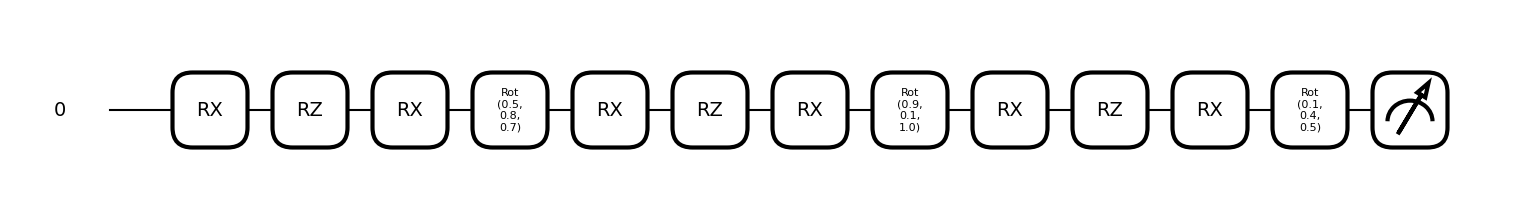

In [5]:
qml.draw_mpl(circuit, decimals=1)(inputs, weights)

In [6]:
out = circuit(inputs, weights)
out

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.85072976, 0.79221255, 0.4284486 ], dtype=float32)>

In [7]:
class DRLayer(tf.keras.layers.Layer):
    def __init__(self,circuit:qml.QNode,layers:int):
        super().__init__()
        self.circuit = circuit
        self.qubits =  len(circuit.device.wires)
        self.layers = layers

    def build(self, input_shape):
        self.layer_weights = self.add_weight(
            shape=(self.layers, 3),
            initializer=tf.keras.initializers.RandomUniform(minval=-np.pi, maxval=np.pi, seed=None),
            trainable=True
        )
        self.built = True
    
    def compute_output_shape(self,input_shape):
        return (input_shape[0],)

    def call(self, inputs):
        outputs = circuit(inputs, self.layer_weights)
        return outputs

## Feynman Equations 

In [8]:
function_dict = {
    "I.6.2": {
        "vars": 2,
        "f": lambda x: tf.exp(-(x[:, 0]**2) / (2 * x[:, 1]**2)) / tf.sqrt(2 * np.pi * x[:, 1]**2),
    },
    "I.6.2b": {
        "vars": 3,
        "f": lambda x: tf.exp(-((x[:, 0] - x[:, 1])**2) / (2 * x[:, 2]**2)) / tf.sqrt(2 * np.pi * x[:, 2]**2),
    },
    "I.9.18": {
        "vars": 6,
        "f": lambda x: x[:, 0] / ((x[:, 1] - 1)**2 + (x[:, 2] - x[:, 3])**2 + (x[:, 4] - x[:, 5])**2),
    },
    "I.12.11": {
        "vars": 2,
        "f": lambda x: 1 + x[:, 0] * tf.sin(x[:, 1]),
    },
    "I.13.12": {
        "vars": 2,
        "f": lambda x: x[:, 0] * (1 / x[:, 1] - 1),
    },
    "I.15.3x": {
        "vars": 2,
        "f": lambda x: (1 - x[:, 0]) / tf.sqrt(1 - x[:, 1]**2),
    },
    "I.16.6": {
        "vars": 2,
        "f": lambda x: (x[:, 0] + x[:, 1]) / (1 + x[:, 0] * x[:, 1]),
    },
    "I.18.4": {
        "vars": 2,
        "f": lambda x: (1 + x[:, 0] * x[:, 1]) / (1 + x[:, 0]),
    },
    "I.26.2": {
        "vars": 2,
        "f": lambda x: tf.asin(x[:, 0] * tf.sin(x[:, 1])),
    },
    "I.27.6": {
        "vars": 2,
        "f": lambda x: 1 / (1 + x[:, 0] * x[:, 1]),
    },
    "I.29.16": {
        "vars": 3,
        "f": lambda x: tf.sqrt(1 + x[:, 0]**2 - 2 * x[:, 0] * tf.cos(x[:, 1] - x[:, 2])),
    },
    "I.30.3": {
        "vars": 2,
        "f": lambda x: tf.sin(x[:, 0] * x[:, 1] / 2)**2 / tf.sin(x[:, 1] / 2)**2,
    },
    "I.30.5": {
        "vars": 2,
        "f": lambda x: tf.asin(x[:, 0] / x[:, 1]),  # Clip values for asin
    },
    "I.37.4": {
        "vars": 2,
        "f": lambda x: 1 + x[:, 0] + 2 * tf.sqrt(x[:, 0]) * tf.cos(x[:, 1]),  # Ensure sqrt argument is non-negative
    },
    "I.40.1": {
        "vars": 2,
        "f": lambda x: x[:, 0] * tf.exp(-x[:, 1]),
    },
    "I.44.4": {
        "vars": 2,
        "f": lambda x: x[:, 0] * tf.math.log(x[:, 1]),  # Ensure log argument is positive
    },
    "I.50.26": {
        "vars": 2,
        "f": lambda x: tf.cos(x[:, 0]) + x[:, 1] * tf.cos(x[:, 0]) ** 2,
    },
    "II.2.42": {
        "vars": 2,
        "f": lambda x: (x[:, 0] - 1) * x[:, 1],
    },
    "II.6.15a": {
        "vars": 3,
        "f": lambda x: (1 / (4 * tf.constant(np.pi, dtype=tf.float64))) * x[:, 2] * tf.sqrt(x[:, 0] ** 2 + x[:, 1] ** 2),  # Ensure sqrt argument is non-negative
    },
    "II.11.7": {
        "vars": 3,
        "f": lambda x: x[:, 0] * (1 + x[:, 1] * tf.cos(x[:, 2])),
    },
    "II.11.27": {
        "vars": 2,
        "f": lambda x: x[:, 0] * x[:, 1] / (1 - x[:, 0] * x[:, 1] / 3),
    },
    "II.35.18": {
        "vars": 2,
        "f": lambda x: x[:, 0] / (tf.exp(x[:, 1]) - tf.exp(-x[:, 1])),
    },
    "II.36.38": {
        "vars": 3,
        "f": lambda x: x[:, 0] + x[:, 1] * x[:, 2],
    },
    "II.38.3": {
        "vars": 2,
        "f": lambda x: x[:, 0] / (x[:, 1]),
    },
    "III.9.52": {
        "vars": 3,
        "f": lambda x: x[:, 0] * (tf.sin((x[:, 1] - x[:, 2]) / 2) ** 2) / ((x[:, 1] - x[:, 2]) ** 2 / 2),
    },
    "III.10.19": {
        "vars": 2,
        "f": lambda x: tf.sqrt(1 + x[:, 0] ** 2 + x[:, 1] ** 2),
    },
    "III.17.37": {
        "vars": 3,
        "f": lambda x: x[:, 2] * (1 + x[:, 0] * tf.cos(x[:, 1])),
    },
}

In [9]:
# f = lambda x: np.exp(-(x[:, 0]**2) / (2 * x[:, 1]**2)) / np.sqrt(2 * np.pi * x[:, 1]**2)
f = function_dict['I.16.6']['f']
feature_dim = function_dict['I.16.6']['vars']

# Generate random data
x = np.random.uniform(-1, 1, (1000, feature_dim))
y = f(x)

# Normalize y to the range [-1, 1]
y = 2 * (y - np.min(y)) / (np.max(y) - np.min(y)) - 1

# Proper train-test split
train_size = 800
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [10]:
inp = Input(shape=(feature_dim,))
out = DRLayer(circuit=circuit, layers=5)(inp)
model = Model(inputs=inp, outputs=out, name="DR")
model.summary()

Model: "DR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dr_layer (DRLayer)              │ (None)                 │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15 (60.00 B)

 Trainable params: 15 (60.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
mae_loss = tf.keras.losses.MeanAbsoluteError()

In [ ]:
batch_size = 20
val_batch_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(val_batch_size)

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            predictions = model(x_batch, training=True)
            loss = mae_loss(y_batch, predictions)

        gradients = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(gradients, model.trainable_weights))
        print(f"Step {step + 1}, Batch Loss: {loss:.4f}", end="\r")

    val_loss = 0
    val_steps = 0
    for x_batch, y_batch in val_dataset:
        val_predictions = model(x_batch, training=False)
        val_loss += mae_loss(y_batch, val_predictions)
        val_steps += 1
    val_loss /= val_steps
    print(f"\nValidation Loss: {val_loss:.4f}")

In [ ]:
# Get predictions for the entire validation set
val_predictions = []
val_true = []

for x_batch, y_batch in val_dataset:
    preds = model(x_batch, training=False)
    val_predictions.append(preds.numpy())
    val_true.append(y_batch.numpy())

# Concatenate all batches to form arrays
val_predictions = np.concatenate(val_predictions, axis=0)
val_predictions = (val_predictions + 1) * (np.max(y_train) - np.min(y_train)) / 2 + np.min(y_train)
val_true = np.concatenate(val_true, axis=0)
loss = mae_loss(val_predictions, val_true)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot true values
ax.scatter(x_val[:, 0], x_val[:, 1], val_true, color='blue', label='True Values', alpha=0.6)

# Plot predicted values
ax.scatter(x_val[:, 0], x_val[:, 1], val_predictions, color='red', label='Predictions', alpha=0.6)

# Set labels and legend
ax.set_xlabel('Feature 1 (x[:, 0])')
ax.set_ylabel('Feature 2 (x[:, 1])')
ax.set_zlabel('Output (y)')
ax.set_title('3D Scatter Plot of True and Predicted Values (Validation Set)')
ax.legend()

# Show the plot
plt.show()

### Loop over all the eqn.

In [11]:
def generate_domain_I_30_5():
    a = np.random.uniform(-1, 1, size=(1000, 1))
    n = np.random.uniform(np.abs(a), 1, size=(1000, 1))
    return np.hstack((a, n))

def generate_domain_I_37_4():
    a = np.random.uniform(0, 1, size=(1000, 1))  # x[0] >= 0
    n = np.random.uniform(-np.pi, np.pi, size=(1000, 1))  # x[1] in [-π, π]
    return np.hstack((a, n))

def generate_domain_I_44_4():
    a = np.random.uniform(-1, 1, size=(1000, 1))
    n = np.random.uniform(1e-3, 1, size=(1000, 1))  # x[1] > 0
    return np.hstack((a, n))

In [12]:
def generate_dataset(function_id, feature_dim, generator_function):
    if (function_id == "I.30.5"):
        x = generate_domain_I_30_5()
    elif (function_id == "I.37.4"):
        x = generate_domain_I_37_4()
    elif (function_id == "I.44.4"):
        x = generate_domain_I_44_4()
    else:
        x = np.random.uniform(-1, 1, (1000, feature_dim))
    y = generator_function(x)

    # Normalize y to the range [-1, 1]
    y = 2 * (y - np.min(y)) / (np.max(y) - np.min(y)) - 1
    
    train_size = 800
    x_train, x_val = x[:train_size], x[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    return x_train, x_val, y_train, y_val, np.min(y), np.max(y)

In [13]:
def build_model(circuit, feature_dim, layers):
    inp = Input(shape=(feature_dim,))
    out = DRLayer(circuit=circuit, layers=layers)(inp)
    model = Model(inputs=inp, outputs=out, name="DR")
    return model

In [14]:
def rmse_loss(y_pred, y_true):
    loss = tf.sqrt(tf.reduce_mean((y_pred - y_true)**2))
    return loss

In [15]:
mae_loss = tf.keras.losses.MeanAbsoluteError()

In [94]:
def train_function(x_train, x_val, y_train, y_val, y_min, y_max):
    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    # loss_fn = mae_loss
    loss_fn = rmse_loss

    epochs = 10
    batch_size = 20
    val_batch_size = 20

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(val_batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                predictions = tf.cast(predictions, dtype=tf.float64)
                # predictions = (predictions + 1) * (y_max - y_min) / 2 + y_min     # inverse rescaling
                loss = loss_fn(y_batch, predictions)

            gradients = tape.gradient(loss, model.trainable_weights)
            opt.apply_gradients(zip(gradients, model.trainable_weights))
            print(f"Step {step + 1}, Batch Loss: {loss:.4f}", end="\r")

        val_loss = 0
        val_steps = 0
        for x_batch, y_batch in val_dataset:
            val_predictions = model(x_batch, training=False)
            val_predictions = tf.cast(val_predictions, dtype=tf.float64)
            # val_predictions = (val_predictions + 1) * (y_max - y_min) / 2 + y_min     # inverse rescaling
            val_loss += loss_fn(y_batch, val_predictions)
            val_steps += 1
        val_loss /= val_steps
        print(f"\nValidation Loss: {val_loss:.4f}")
    return model, val_loss.numpy()

In [ ]:
results = []
for key, value in function_dict.items():
    print("\nTraining function ", key)
    function_name = key
    feature_dim = value['vars']
    generator_function = value['f']
    x_train, x_val, y_train, y_val, y_min, y_max = generate_dataset(function_name, feature_dim, generator_function)
    model = build_model(circuit=circuit, feature_dim=feature_dim, layers=5)
    model, final_loss = train_function(x_train, x_val, y_train, y_val, y_min, y_max)
    results.append({"Function": function_name, "Final Loss": final_loss})
    # break
result_df = pd.DataFrame(results)

In [111]:
time_date = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
result_df.to_csv(f"results/feynman_vanilla_dr/results_{time_date}.csv", index=False)

## DR code for univariate approximation:

In [8]:
def step(x):
    step.name = 'step'
    return 0.5 * (np.sign(x) + 1)

def sigmoid(x, a=10):
    sigmoid.name = 'sigmoid'
    return 1 / (1 + np.exp(-a * x))

def tanh(x, a=5):
    tanh.name = 'tanh'
    return np.tanh(a * x)

def relu(x):
    relu.name = 'relu'
    return x * (x > 0)

def poly(x):
    poly.name= 'poly'
    return np.abs(3*x**3 * (1 - x**4))

def func1(x):
    func1.name = 'func1'
    return np.exp(np.sin(x))/np.e

def func2(x):
    func2.name = 'func2'
    return (0.01*(x**4) - 0.1*(x**3) + 3*x**2 - x - 10)/500

def func3(x):
    func3.name = 'func3'
    return (np.exp(np.sin(x))*(x**3) + x**2)/1500

def func4(x):
    func4.name = 'func4'
    return (np.exp(np.sin(x))*np.tanh(x**3) + (1-np.exp(np.cos(x)))*x**2)/60

In [9]:
@qml.qnode(device=dev, interface="tf")
def circuit(inputs, weights):
    for layer in range(weights.shape[0]):
        # upload inputs in groups of 2 or 3(for Rot() gates)
        for i in range(0, inputs.shape[-1], 2):
            # qml.Rot(*tf.unstack(inputs[:, i: i + 3], axis=1), wires=0)
            qml.RX(inputs[:,i], wires=0)
            if (i+1 < inputs.shape[-1]):
                qml.RZ(inputs[:,i+1], wires=0)
        qml.Rot(*weights[layer], wires=0)
    return qml.expval(qml.PauliZ(0))

In [10]:
# @qml.qnode(device=dev, interface="tf")
# def circuit(inputs, weights):
#     for layer in range(weights.shape[0]):
#         # upload inputs in groups of 2 or 3(for Rot() gates)
#         for i in range(0, inputs.shape[-1], 2):
#             qml.RX(inputs[:,i], wires=0)
#         qml.Rot(*weights[layer], wires=0)
#     return qml.expval(qml.PauliZ(0))

In [11]:
class DRLayer(tf.keras.layers.Layer):
    def __init__(self,circuit:qml.QNode,layers:int):
        super().__init__()
        self.circuit = circuit
        self.qubits =  len(circuit.device.wires)
        self.layers = layers

    def build(self, input_shape):
        self.layer_weights = self.add_weight(
            shape=(self.layers, 3),
            initializer=tf.keras.initializers.RandomUniform(minval=-np.pi, maxval=np.pi, seed=None),
            trainable=True
        )
        self.built = True
    
    def compute_output_shape(self,input_shape):
        return (input_shape[0],)

    def call(self, inputs):
        outputs = circuit(inputs, self.layer_weights)
        return outputs

In [12]:
# def create_dataset():
#     x = np.linspace(-1, 1, 100)
#     y = poly(x)
#     return x, y

In [13]:
def create_dataset(func_name):
    x = np.linspace(-1, 1, 100)
    y = func_name(x)
    return x, y

In [14]:
def build_model(feature_dim, layers=5):
    inp = Input(shape=(feature_dim,))
    out = DRLayer(circuit=circuit, layers=layers)(inp)
    model = Model(inputs=inp, outputs=out, name="DR")
    return model

In [15]:
def train_function(x_train, y_train, model, lossfn, opt, lossfn1, epochs=50):
    for epoch in range(epochs + 1):
        with tf.GradientTape() as tape:
            predictions = model(x_train, training=True)
            loss = lossfn(y_train, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(gradients, model.trainable_weights))
        if(epoch%50==0):
            plt.plot(x_train, y, label="True")
            plt.scatter(x_train,predictions, label="Predicted", color='red', s=10)
            plt.title(f"DR Function epoch {epoch}")
            plt.grid(True)
            plt.show()
        print(f"Epoch {epoch} | loss:{tf.reduce_mean(loss)}",end="\r")
    return float(tf.reduce_mean(loss).numpy())

In [24]:
def cosine_lr(epoch, total_epochs, lr_max, lr_min=1e-6):
    """Cosine decay learning-rate schedule."""
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(np.pi * epoch / total_epochs))

def train_function(x_train, y_train, model, lossfn, opt, lossfn1=None,
                   epochs=50, lr_max=1e-3, lr_min=1e-6):

    for epoch in range(epochs + 1):

        # ---- Update learning rate using cosine decay ----
        new_lr = cosine_lr(epoch, epochs, lr_max, lr_min)
        opt.learning_rate.assign(new_lr)

        # ---- Forward + backward pass ----
        with tf.GradientTape() as tape:
            predictions = model(x_train, training=True)
            loss = lossfn(y_train, predictions)

        gradients = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(gradients, model.trainable_weights))

        # ---- Plot every 50 epochs ----
        if epoch % 50 == 0:
            plt.plot(x_train, y_train, label="True")
            plt.scatter(x_train, predictions, color='red', s=10, label="Predicted")
            plt.title(f"DR Function - Epoch {epoch} | LR={new_lr:.6f}")
            plt.grid(True)
            plt.legend()
            plt.show()

        print(f"Epoch {epoch}/{epochs} | loss: {tf.reduce_mean(loss):.6f} | LR: {new_lr:.6e}", end="\r")

    return float(tf.reduce_mean(loss).numpy())

In [16]:
def train_function(x_train, y_train, model, lossfn, opt, lossfn1, epochs=50, opt1=None, opt2=None):
    for epoch in range(epochs + 1):
        with tf.GradientTape() as tape:
            predictions = model(x_train, training=True)
            # if(epoch < 50):
            #     loss = lossfn1(y_train, predictions)
            # else:
            #     loss = lossfn(y_train, predictions)
            loss = lossfn(y_train, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        if(epoch < 111):
            opt.apply_gradients(zip(gradients, model.trainable_weights))
        elif(epoch < 181):
            opt1.apply_gradients(zip(gradients, model.trainable_weights))
        else:
            opt2.apply_gradients(zip(gradients, model.trainable_weights))
        if(epoch%50==0):
            plt.plot(x_train, y, label="True")
            plt.scatter(x_train,predictions, label="Predicted", color='red', s=10)
            plt.title(f"DR Function epoch {epoch}")
            plt.grid(True)
            plt.show()
        print(f"Epoch {epoch} | loss:{tf.reduce_mean(loss)}",end="\r")
    return float(tf.reduce_mean(loss).numpy())

In [17]:
def rescale_inputs(x):
    #x = np.divide(x, np.abs(np.max(x)))
    #x = (x + 1) / 2
    #x = np.multiply(x, np.pi)
    return x

In [18]:
def mae_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred)**2)*10

In [19]:
def rmse_loss(y_pred, y_true):
    loss = tf.sqrt(tf.reduce_mean((y_pred - y_true)**2))*10
    return loss

In [20]:
def mse_loss(y_pred, y_true):
    loss = tf.reduce_mean((y_pred - y_true)**2)*10
    return loss

In [21]:
funname_dict={relu: "relu",
              poly: "poly",
              func1: "func1",
              func2: "func2",
              func3: "func3",
              func4: "func4",
              step: "step",
              sigmoid: "sigmoid",
              tanh: "tanh",
              }

In [22]:
funname_dict={#poly: "poly",
            #   func2: "func2",
            #   func3: "func3",
              # func4: "func4",
              #step: "step",
              # sigmoid: "sigmoid",
              tanh: "tanh",
              }

In [ ]:
import pandas as pd

results = []
for func, name in funname_dict.items():
    print(f"Training function {name}")
    x, y = create_dataset(func)
    y = 2 * (y - np.min(y)) / (np.max(y) - np.min(y)) - 1
    x_train = rescale_inputs(x)
    model = build_model(1, 20)
    opt  = tf.keras.optimizers.Adam(learning_rate=0.05)
    opt1  = tf.keras.optimizers.Adam(learning_rate=0.04)
    opt2  = tf.keras.optimizers.Adam(learning_rate=0.1)
    lossfn = rmse_loss
    lossfn1 = rmse_loss
    epochs = 400
    # Train and get final loss (modify train_function to return final loss)
    final_loss = train_function(x_train, y, model, lossfn, opt, lossfn1, epochs,opt1, opt2)
    num_params = model.count_params()
    results.append({
        "Function": name,
        "Num_Params": num_params,
        "Final_Loss": float(final_loss) if hasattr(final_loss, 'numpy') else final_loss,
        "epochs": epochs,
        "loss fun": 'mae'
    })

In [23]:
results

[{'Function': 'relu',
  'Num_Params': 27,
  'Final_Loss': 0.2838659882545471,
  'epochs': 400,
  'loss fun': 'mae'},
 {'Function': 'poly',
  'Num_Params': 27,
  'Final_Loss': 1.9040626287460327,
  'epochs': 400,
  'loss fun': 'mae'},
 {'Function': 'func1',
  'Num_Params': 27,
  'Final_Loss': 0.30459487438201904,
  'epochs': 400,
  'loss fun': 'mae'},
 {'Function': 'func2',
  'Num_Params': 27,
  'Final_Loss': 0.21385008096694946,
  'epochs': 400,
  'loss fun': 'mae'},
 {'Function': 'func3',
  'Num_Params': 27,
  'Final_Loss': 0.3301410675048828,
  'epochs': 400,
  'loss fun': 'mae'},
 {'Function': 'func4',
  'Num_Params': 27,
  'Final_Loss': 0.6834577918052673,
  'epochs': 400,
  'loss fun': 'mae'},
 {'Function': 'step',
  'Num_Params': 27,
  'Final_Loss': 2.595576286315918,
  'epochs': 400,
  'loss fun': 'mae'},
 {'Function': 'sigmoid',
  'Num_Params': 27,
  'Final_Loss': 0.2845478653907776,
  'epochs': 400,
  'loss fun': 'mae'},
 {'Function': 'tanh',
  'Num_Params': 27,
  'Final_Loss'

In [24]:
results_df = pd.DataFrame(results)

In [25]:
results_df

,Function,Num_Params,Final_Loss,epochs,loss fun
0,relu,27,0.283866,400,mae
1,poly,27,1.904063,400,mae
2,func1,27,0.304595,400,mae
3,func2,27,0.213850,400,mae
4,func3,27,0.330141,400,mae
5,func4,27,0.683458,400,mae
6,step,27,2.595576,400,mae
7,sigmoid,27,0.284548,400,mae
8,tanh,27,0.288982,400,mae


In [ ]:
x, y = create_dataset(func1)
model = build_model(1, 7)
x_train = rescale_inputs(x)
opt  = tf.keras.optimizers.SGD(learning_rate=0.01)
lossfn = mae_loss
lossfn1= mae_loss
train_function(x_train, y, model, lossfn, opt, lossfn1)